# HarveST Complete Analysis: Clustering + Spatial Gene Discovery

This notebook demonstrates a complete spatial transcriptomics analysis workflow using HarveST:
1. **Clustering Analysis**: Identify spatial domains using graph neural networks
2. **Spatial Gene Discovery**: Find domain-specific spatial variable genes using Random Walk with Restart

---

## Setup and Imports

In [37]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import torch
import random
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Import HarveST
from harvest import Harvest

# Set up plotting
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white')
plt.rcParams['figure.figsize'] = (10, 8)

print("All imports successful!")

All imports successful!


In [38]:
def setup_seed(seed):
    """Set random seed for reproducibility across all libraries."""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

setup_seed(2023)
print("Random seed set to 2023 for reproducibility")

Random seed set to 2023 for reproducibility


## Configuration and Data Paths

**Please modify these paths according to your data setup:**

In [39]:
# Data paths - MODIFY THESE ACCORDING TO YOUR SETUP
matrix_dir = "/data2/fanruibo/xiaobao/ST/sup/results_151674_2"  # Directory with preprocessed matrices
original_data_path = "/data2/fanruibo/xiaobao/ST/Data/for_submit/151674/"  # Original Visium data

output_dir = "./harvest_complete_analysis"     # Output directory for results

# Analysis parameters
n_clusters = 7          # Number of clusters to identify
n_top_genes = 3000      # Number of highly variable genes
domain_column = 'Ground Truth'  # Column name for domain labels

print(f"Matrix directory: {matrix_dir}")
print(f"Original data path: {original_data_path}")
print(f"Output directory: {output_dir}")
print(f"Analysis parameters: {n_clusters} clusters, {n_top_genes} genes")

Matrix directory: /data2/fanruibo/xiaobao/ST/sup/results_151674_2
Original data path: /data2/fanruibo/xiaobao/ST/Data/for_submit/151674/
Output directory: ./harvest_complete_analysis
Analysis parameters: 7 clusters, 3000 genes


## Data Validation

Check if all required files exist before proceeding:

In [40]:
# Check if required directories exist
required_dirs = [matrix_dir, original_data_path]
missing_dirs = [d for d in required_dirs if not os.path.exists(d)]

if missing_dirs:
    print("❌ Missing directories:")
    for d in missing_dirs:
        print(f"   - {d}")
    print("\nPlease update the paths in the configuration cell above.")
else:
    print("✅ All required directories found")

# Check if required preprocessed files exist
required_files = [
    "df_gene2gene.csv",
    "df_cell2cell.csv", 
    "df_cell2gene.csv",
    "feat_cell.npy",
    "feat_gene.npy"
]

missing_files = []
for file in required_files:
    if not os.path.exists(os.path.join(matrix_dir, file)):
        missing_files.append(file)

if missing_files:
    print("❌ Missing preprocessed files:")
    for f in missing_files:
        print(f"   - {f}")
    print("\nPlease run preprocessing first to generate these files.")
else:
    print("✅ All required preprocessed files found")

# Create output directory
os.makedirs(output_dir, exist_ok=True)
print(f"✅ Output directory created: {output_dir}")

✅ All required directories found
✅ All required preprocessed files found
✅ Output directory created: ./harvest_complete_analysis


---
# Part 1: Clustering Analysis

Identify spatial domains using HarveST's graph neural network approach.

## Initialize HarveST and Load Data

In [41]:
# Initialize HarveST for clustering
harvest_cluster = Harvest(output_dir=os.path.join(output_dir, "clustering"))

print("Loading preprocessed data for clustering...")

# Load preprocessed data
harvest_cluster.load_preprocessed_data(
    matrix_dir=matrix_dir,
    data_path=original_data_path,
    count_file="filtered_feature_bc_matrix.h5",
    n_top_genes=n_top_genes,
    load_ground_truth=True
)

print("✅ Data loaded successfully for clustering")

INFO - HarveST initialized with device: cuda
INFO - Loading preprocessed data from /data2/fanruibo/xiaobao/ST/sup/results_151674_2


Loading preprocessed data for clustering...


INFO - Reconstructing AnnData from original data: /data2/fanruibo/xiaobao/ST/Data/for_submit/151674/
INFO - Loading Visium data from: /data2/fanruibo/xiaobao/ST/Data/for_submit/151674/


reading /data2/fanruibo/xiaobao/ST/Data/for_submit/151674/filtered_feature_bc_matrix.h5
 (0:00:00)


INFO - Successfully loaded Visium data with shape (3673, 33538)
INFO - Loading ground truth from /data2/fanruibo/xiaobao/ST/Data/for_submit/151674/151674_truth.txt
INFO - Ground truth labels loaded successfully
INFO - Preprocessing data...


extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)


INFO - Selected 3000 highly variable genes
INFO - AnnData consistency check passed
INFO - AnnData reconstructed successfully from original data
INFO - Preprocessed data loaded successfully!


✅ Data loaded successfully for clustering


## Run Clustering Analysis

In [6]:
print("Starting clustering analysis...")
print("This may take several minutes depending on your data size and hardware.")

# Run clustering
clustering_results = harvest_cluster.cluster(
    n_clusters=n_clusters,
    plot_results=True,
    save_results=True
)

print("✅ Clustering analysis completed!")

INFO - Starting clustering analysis...


Starting clustering analysis...
This may take several minutes depending on your data size and hardware.


INFO - Starting training for 2000 epochs
INFO - Epoch: 100, Loss: 0.4779, Loss_c: 0.1377, Loss_g: 0.3402
INFO - Epoch: 200, Loss: 0.4416, Loss_c: 0.1346, Loss_g: 0.3070
INFO - Epoch: 300, Loss: 0.4255, Loss_c: 0.1328, Loss_g: 0.2927
INFO - Epoch: 400, Loss: 0.4214, Loss_c: 0.1317, Loss_g: 0.2897
INFO - Epoch: 500, Loss: 0.4205, Loss_c: 0.1308, Loss_g: 0.2897
INFO - Epoch: 600, Loss: 0.4188, Loss_c: 0.1301, Loss_g: 0.2887
INFO - Epoch: 700, Loss: 0.4182, Loss_c: 0.1294, Loss_g: 0.2888
INFO - Epoch: 800, Loss: 0.4196, Loss_c: 0.1289, Loss_g: 0.2907
INFO - Epoch: 900, Loss: 0.4173, Loss_c: 0.1288, Loss_g: 0.2885
INFO - Epoch: 1000, Loss: 0.4163, Loss_c: 0.1278, Loss_g: 0.2885
INFO - Epoch: 1100, Loss: 0.4161, Loss_c: 0.1276, Loss_g: 0.2885
INFO - Epoch: 1200, Loss: 0.4164, Loss_c: 0.1272, Loss_g: 0.2892
INFO - Epoch: 1300, Loss: 0.4152, Loss_c: 0.1267, Loss_g: 0.2885
INFO - Epoch: 1400, Loss: 0.4149, Loss_c: 0.1265, Loss_g: 0.2884
INFO - Epoch: 1500, Loss: 0.4156, Loss_c: 0.1271, Loss_g: 

fitting ...
  |======================================================================| 100%


INFO - mclust Adjusted rand index = 0.6913
INFO - Applying SVM refinement strategies
INFO - svm_or_clust Adjusted rand index = 0.6813
INFO - svm1_or_clust Adjusted rand index = 0.6526
INFO - Applying spatial refinement with radius 50
INFO - svm1_or_clust_refined Adjusted rand index = 0.6759
INFO - svmclust_refined Adjusted rand index = 0.6918
INFO - svm_or_clust_refined Adjusted rand index = 0.6935
INFO - Clustering analysis completed successfully!


✅ Clustering analysis completed!


## Visualize Clustering Results

In [ ]:
# Get the clustered data
adata_clustered = clustering_results["adata"] 

print(f"Data shape: {adata_clustered.shape}")
print(f"Available clustering methods: {[col for col in adata_clustered.obs.columns if 'clust' in col or 'mclust' in col]}")

# Check if ground truth is available
if domain_column in adata_clustered.obs:
    print(f"Ground truth domains: {adata_clustered.obs[domain_column].unique()}")
else:
    print("No ground truth available")

Data shape: (3635, 3000)
Available clustering methods: ['mclust', 'svmclust', 'svm_or_clust', 'svm1clust', 'svm1_or_clust', 'svm1_or_clust_refined', 'svmclust_refined', 'svm_or_clust_refined']
Ground truth domains: ['Layer_3', 'Layer_1', 'WM', 'Layer_5', 'Layer_6', 'Layer_2', 'Layer_4']
Categories (7, object): ['Layer_1', 'Layer_2', 'Layer_3', 'Layer_4', 'Layer_5', 'Layer_6', 'WM']


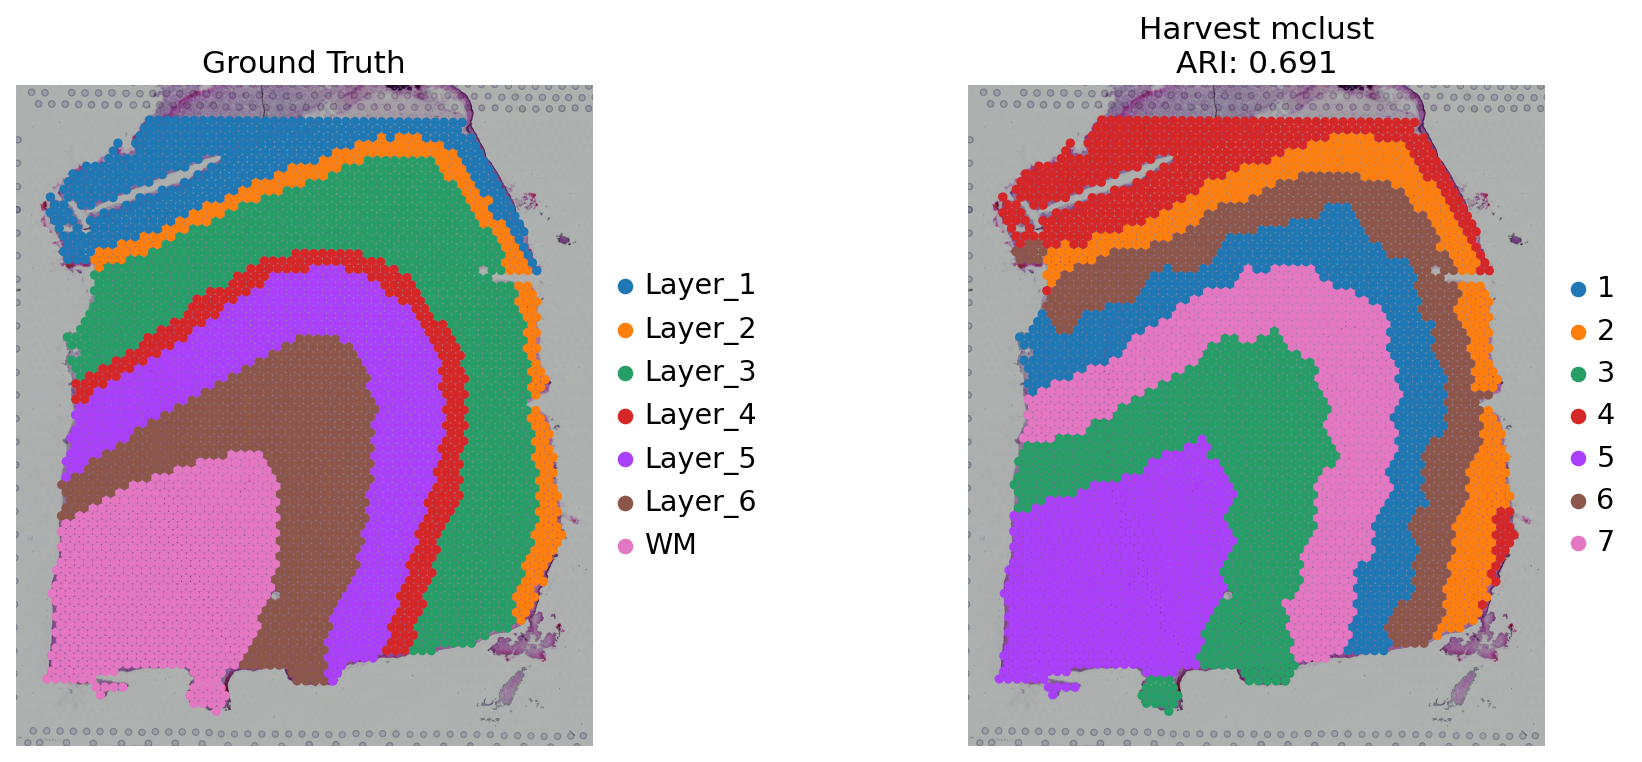

✅ Spatial plots saved to ./harvest_complete_analysis/clustering_results_spatial.png


In [ ]:
# Create spatial plots for different clustering methods
clustering_methods = ['mclust'] # or "svm1_or_clust_refined"
available_methods = [method for method in clustering_methods if method in adata_clustered.obs.columns]

# Add ground truth if available
if domain_column in adata_clustered.obs.columns:
    available_methods.insert(0, domain_column)

# Create subplots
n_methods = len(available_methods)
fig, axes = plt.subplots(1, n_methods, figsize=(6*n_methods, 5))
if n_methods == 1:
    axes = [axes]

# Import ARI function
from sklearn.metrics.cluster import adjusted_rand_score

for i, method in enumerate(available_methods):
    # 构建标题
    if method == domain_column:
        # 对于ground truth，只显示方法名
        title = f'{method}'
    else:
        # 对于聚类方法，添加Harvest和ARI信息
        if domain_column in adata_clustered.obs.columns:
            # 现场计算ARI
            ari_value = adjusted_rand_score(adata_clustered.obs[domain_column], 
                                          adata_clustered.obs[method])
            title = f'Harvest {method}\nARI: {ari_value:.3f}'
        else:
            title = f'Harvest {method}'
    
    sc.pl.spatial(adata_clustered, color=method, ax=axes[i], show=False, 
                  title=title, frameon=False, size=1.5)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "clustering_results_spatial.png"), 
            dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Spatial plots saved to {output_dir}/clustering_results_spatial.png")

## Evaluate Clustering Performance

In [42]:
# Calculate evaluation metrics if ground truth is available
if domain_column in adata_clustered.obs:
    from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score
    
    print("\n Clustering Performance Metrics:")
    print("=" * 50)
    
    for method in available_methods[1:]:  # Skip ground truth
        if method in adata_clustered.obs:
            try:
                # Remove NaN values for evaluation
                obs_df = adata_clustered.obs.dropna(subset=[method, domain_column])
                
                if len(obs_df) > 0:
                    ari = adjusted_rand_score(obs_df[method], obs_df[domain_column])
                    nmi = normalized_mutual_info_score(obs_df[method], obs_df[domain_column])
                    
                    print(f"{method}:")
                    print(f"  ARI: {ari:.4f}")
                    print(f"  NMI: {nmi:.4f}")
                    print()
            except Exception as e:
                print(f"Could not calculate metrics for {method}: {e}")
else:
    print("No ground truth available for evaluation")


 Clustering Performance Metrics:
mclust:
  ARI: 0.6913
  NMI: 0.7744



---
# Part 2: Spatial Gene Discovery

Discover domain-specific spatial variable genes using Random Walk with Restart.

## Initialize HarveST for SVG Discovery

In [10]:
# Initialize HarveST for spatial gene discovery
harvest_svg = Harvest(output_dir=os.path.join(output_dir, "spatial_genes"))

print("Loading data for spatial gene discovery...")

# Load the same preprocessed data
harvest_svg.load_preprocessed_data(
    matrix_dir=matrix_dir,
    data_path=original_data_path,
    count_file="filtered_feature_bc_matrix.h5",
    n_top_genes=n_top_genes,
    load_ground_truth=True
)

print("✅ Data loaded successfully for spatial gene discovery")

INFO - HarveST initialized with device: cuda
INFO - Loading preprocessed data from /data2/fanruibo/xiaobao/ST/sup/results_151674_2


Loading data for spatial gene discovery...


INFO - Reconstructing AnnData from original data: /data2/fanruibo/xiaobao/ST/Data/for_submit/151674/
INFO - Loading Visium data from: /data2/fanruibo/xiaobao/ST/Data/for_submit/151674/


reading /data2/fanruibo/xiaobao/ST/Data/for_submit/151674/filtered_feature_bc_matrix.h5
 (0:00:00)


INFO - Successfully loaded Visium data with shape (3673, 33538)
INFO - Loading ground truth from /data2/fanruibo/xiaobao/ST/Data/for_submit/151674/151674_truth.txt
INFO - Ground truth labels loaded successfully
INFO - Preprocessing data...


extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)


INFO - Selected 3000 highly variable genes
INFO - AnnData consistency check passed
INFO - AnnData reconstructed successfully from original data
INFO - Preprocessed data loaded successfully!


✅ Data loaded successfully for spatial gene discovery


## Run Spatial Gene Discovery

In [ ]:
print("Starting spatial gene discovery...")
print("This process uses Random Walk with Restart to identify domain-specific genes.")
print("Progress will be shown below:")

# Discover spatial genes for all domains
svg_results = harvest_svg.discover_spatial_genes(
    domain_column=domain_column,
    restart_prob=0.1,
    p_value_threshold=0.01,
    num_randomizations=100,  # Reduced for faster example
    use_preprocessed_networks=True
)

print("\n✅ Spatial gene discovery completed!")

INFO - Starting spatial gene discovery...


Starting spatial gene discovery...
This process uses Random Walk with Restart to identify domain-specific genes.
Progress will be shown below:


INFO - Using preprocessed networks for spatial gene discovery
Processing domains:   0%|          | 0/8 [00:00<?, ?it/s]INFO - Analyzing domain: Layer_3
INFO - RWR converged after 14 iterations
INFO - RWR converged after 11 iterations
INFO - RWR converged after 11 iterations
INFO - RWR converged after 11 iterations
INFO - RWR converged after 11 iterations
INFO - RWR converged after 11 iterations
INFO - RWR converged after 11 iterations
INFO - RWR converged after 11 iterations
INFO - RWR converged after 11 iterations
INFO - RWR converged after 11 iterations
INFO - RWR converged after 11 iterations
INFO - RWR converged after 11 iterations
INFO - RWR converged after 11 iterations
INFO - RWR converged after 11 iterations
INFO - RWR converged after 11 iterations
INFO - RWR converged after 11 iterations
INFO - RWR converged after 11 iterations
INFO - RWR converged after 11 iterations
INFO - RWR converged after 11 iterations
INFO - RWR converged after 11 iterations
INFO - RWR converged after 1


✅ Spatial gene discovery completed!


## Analyze SVG Results

In [36]:
# Print results summary
print("\n Spatial Gene Discovery Results:")
print("=" * 50)

svg_summary = {}
for domain, genes_df in svg_results.items():
    if not genes_df.empty:
        n_genes = len(genes_df)
        svg_summary[domain] = n_genes
        
        print(f"\n Domain: {domain}")
        print(f"   Significant genes found: {n_genes}")
        
        if n_genes > 0:
            top_genes = genes_df.head(5)
            print(f"   Top 5 genes:")
            for idx, row in top_genes.iterrows():
                print(f"     {row['Gene']}: Score={row['Score']:.4f}, p-val={row['p_value']:.2e}")
    else:
        print(f"\n Domain: {domain}")
        print(f"   No significant genes found")
        svg_summary[domain] = 0

print(f"\n Summary: Found significant genes in {sum(1 for v in svg_summary.values() if v > 0)} out of {len(svg_summary)} domains")


 Spatial Gene Discovery Results:

 Domain: Layer_3
   Significant genes found: 2222
   Top 5 genes:
     CARTPT: Score=0.0002, p-val=4.76e-02
     HOPX: Score=0.0002, p-val=4.76e-02
     SAA1: Score=0.0002, p-val=4.76e-02
     CALB1: Score=0.0002, p-val=4.76e-02
     CA10: Score=0.0002, p-val=4.76e-02

 Domain: Layer_1
   Significant genes found: 757
   Top 5 genes:
     MYL9: Score=0.0002, p-val=4.76e-02
     RELN: Score=0.0002, p-val=4.76e-02
     ACTA2: Score=0.0002, p-val=4.76e-02
     MGP: Score=0.0002, p-val=4.76e-02
     BAMBI: Score=0.0002, p-val=4.76e-02

 Domain: WM
   Significant genes found: 515
   Top 5 genes:
     MOBP: Score=0.0002, p-val=4.76e-02
     MOG: Score=0.0002, p-val=4.76e-02
     MAG: Score=0.0002, p-val=4.76e-02
     ERMN: Score=0.0002, p-val=4.76e-02
     CLDN11: Score=0.0002, p-val=4.76e-02

 Domain: Layer_5
   Significant genes found: 1736
   Top 5 genes:
     PCP4: Score=0.0002, p-val=4.76e-02
     HS3ST2: Score=0.0002, p-val=4.76e-02
     SMYD2: Score=0

## Visualize SVG Results

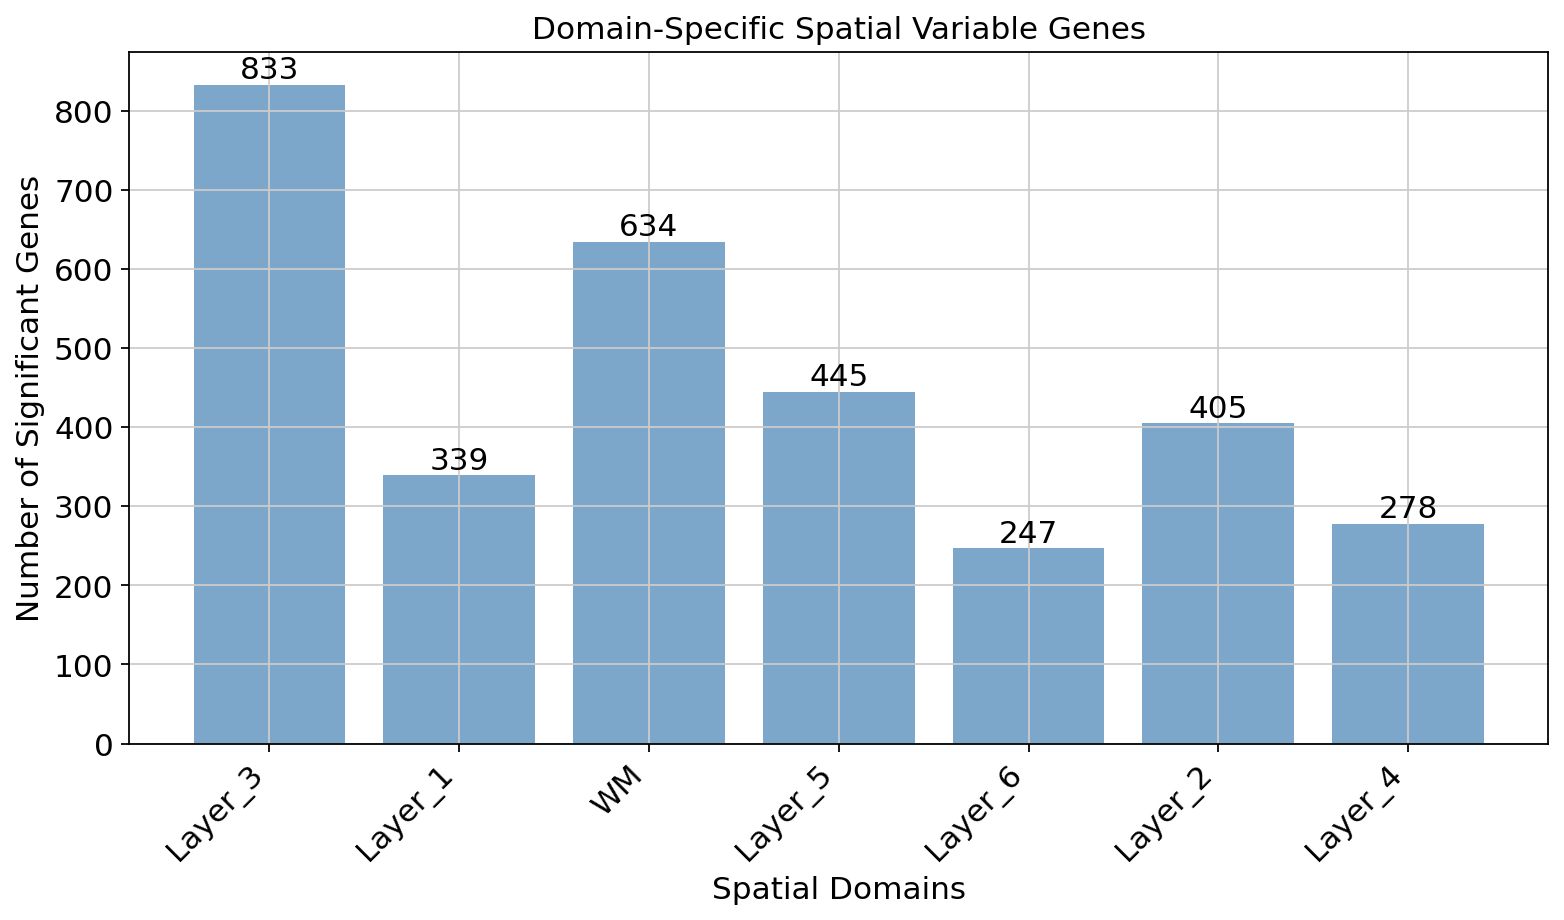

✅ SVG summary plot saved to ./harvest_complete_analysis/svg_summary_barplot.png


In [13]:
# Create a summary plot of significant genes per domain
if svg_summary:
    domains = list(svg_summary.keys())
    gene_counts = list(svg_summary.values())
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(domains, gene_counts, color='steelblue', alpha=0.7)
    plt.xlabel('Spatial Domains')
    plt.ylabel('Number of Significant Genes')
    plt.title('Domain-Specific Spatial Variable Genes')
    plt.xticks(rotation=45, ha='right')
    
    # Add value labels on bars
    for bar, count in zip(bars, gene_counts):
        if count > 0:
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                    str(count), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "svg_summary_barplot.png"), 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ SVG summary plot saved to {output_dir}/svg_summary_barplot.png")
else:
    print("No SVG results to visualize")


 Visualizing Top 3 Spatial Variable Genes for Each Domain

 Visualizing top 3 genes for domain: WM
   Top 3 genes: MOBP, MOG, MAG


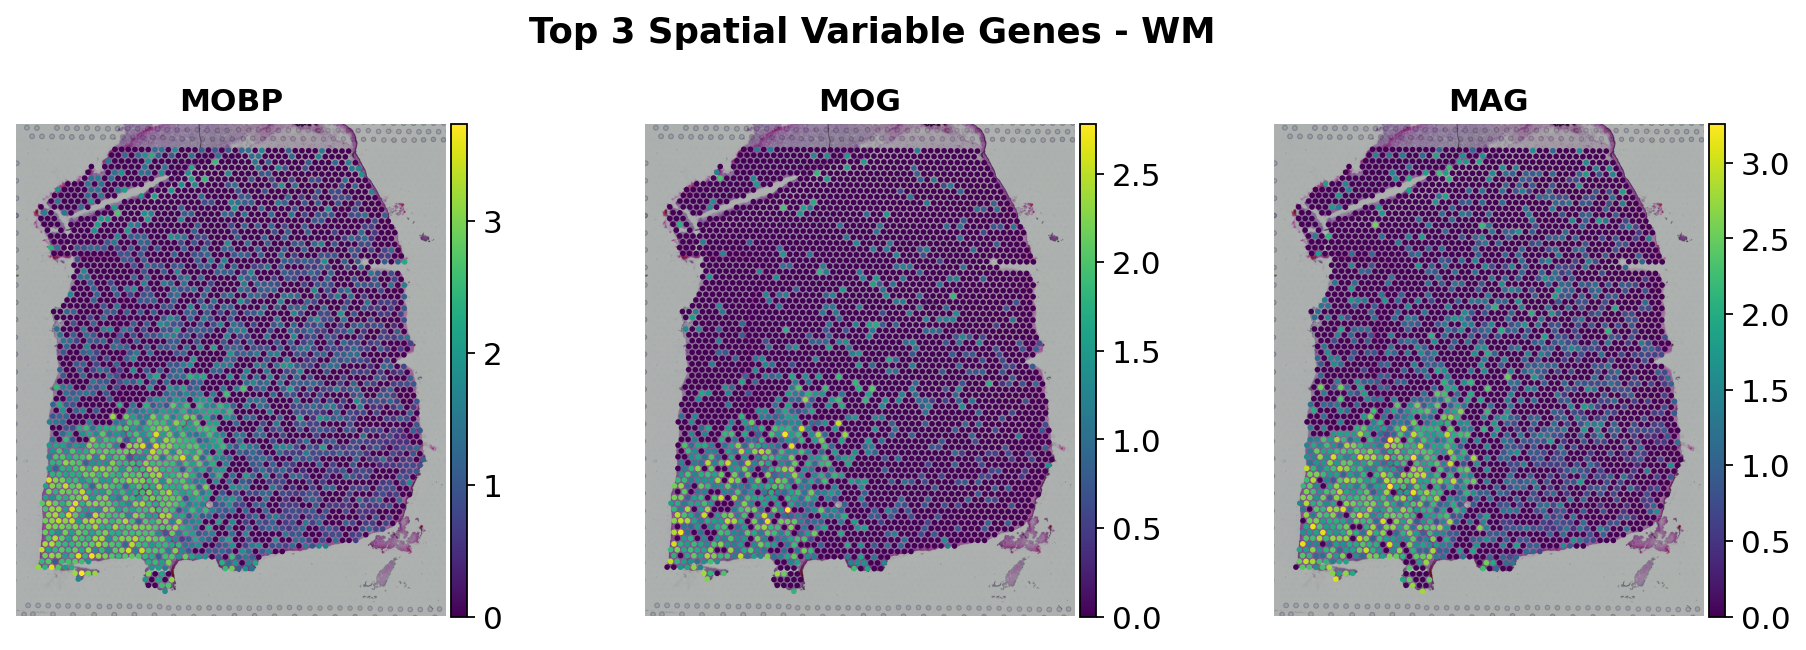

   ✅ Saved combined plot: SVG_WM_top3_combined.png

 Visualizing top 3 genes for domain: Layer_5
   Top 3 genes: PCP4, HS3ST2, SMYD2


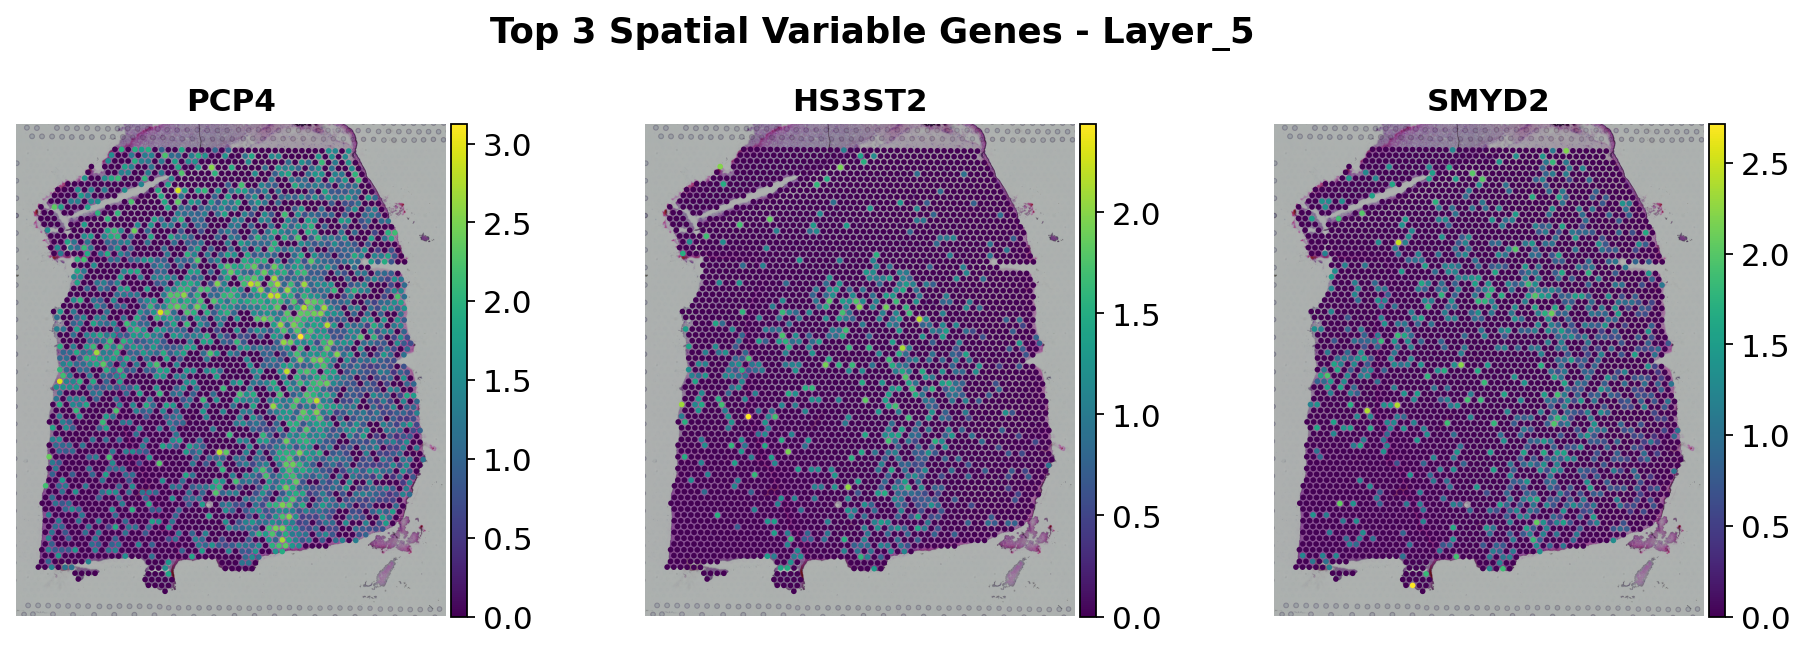

   ✅ Saved combined plot: SVG_Layer_5_top3_combined.png

✅ All spatial gene visualizations saved to: ./harvest_complete_analysis


In [35]:
# Visualize top3 spatial variable genes for each domain
print("\n Visualizing Top 3 Spatial Variable Genes for Each Domain")
print("=" * 60)

# Get clustered adata for visualization
adata_for_viz = clustering_results["adata"]

# Only process specified domains
target_domains = ['WM', 'Layer_5']

for domain, genes_df in svg_results.items():
    # Add domain filter condition
    if domain not in target_domains:
        continue
        
    if not genes_df.empty and len(genes_df) >= 3:
        print(f"\n Visualizing top 3 genes for domain: {domain}")
        
        # Get top3 genes
        top3_genes = genes_df.head(3)['Gene'].tolist()
        print(f"   Top 3 genes: {', '.join(top3_genes)}")
        
        # Filter genes that exist in the data
        available_genes = [gene for gene in top3_genes if gene in adata_for_viz.var_names]
        
        if available_genes:
            # Create side-by-side subplots
            n_genes = len(available_genes)
            fig, axes = plt.subplots(1, n_genes, figsize=(4*n_genes, 4))
            
            # Ensure axes is array if only one gene
            if n_genes == 1:
                axes = [axes]
            
            # Create spatial visualization for each gene
            for i, gene in enumerate(available_genes):
                # Plot spatial expression
                sc.pl.spatial(adata_for_viz, basis="spatial", color=gene, 
                            title=gene, show=False, ax=axes[i], size=1.2)
                
                # Set title and style
                axes[i].set_title(f"{gene}", fontsize=14, fontweight='bold')
                axes[i].spines['top'].set_visible(False)
                axes[i].spines['right'].set_visible(False)
                axes[i].spines['left'].set_visible(False)
                axes[i].spines['bottom'].set_visible(False)
                axes[i].set_xticks([])
                axes[i].set_yticks([])
                axes[i].set_xlabel('')
                axes[i].set_ylabel('')
            
            # Set overall title, increase y-value to give more space
            fig.suptitle(f"Top {n_genes} Spatial Variable Genes - {domain}", 
                        fontsize=16, fontweight='bold', y=1.02)
            
            # Adjust layout, increase top value for title space
            plt.tight_layout()
            plt.subplots_adjust(top=0.85)
            
            # Save image
            safe_domain_name = domain.replace('/', '_').replace('\\', '_').replace(' ', '_')
            filename = f"SVG_{safe_domain_name}_top{n_genes}_combined.png"
            filepath = os.path.join(output_dir, filename)
            plt.savefig(fname=filepath, bbox_inches='tight', pad_inches=0.1, dpi=300)
            plt.show()
            
            print(f"   ✅ Saved combined plot: {filename}")
            
            # Report missing genes
            missing_genes = [gene for gene in top3_genes if gene not in adata_for_viz.var_names]
            if missing_genes:
                print(f"    Genes not found in expression data: {', '.join(missing_genes)}")
        else:
            print(f"    None of the top 3 genes found in expression data")
    
    elif not genes_df.empty and len(genes_df) < 3:
        print(f"\n Domain {domain}: Only {len(genes_df)} significant genes found (less than 3)")
        
        # Get all available genes
        all_genes = genes_df['Gene'].tolist()
        available_genes = [gene for gene in all_genes if gene in adata_for_viz.var_names]
        
        if available_genes:
            print(f"   Available genes: {', '.join(available_genes)}")
            
            # Create side-by-side subplots
            n_genes = len(available_genes)
            fig, axes = plt.subplots(1, n_genes, figsize=(4*n_genes, 4))
            
            # Ensure axes is array if only one gene
            if n_genes == 1:
                axes = [axes]
            
            # Create spatial visualization for each gene
            for i, gene in enumerate(available_genes):
                sc.pl.spatial(adata_for_viz, basis="spatial", color=gene, 
                            title=gene, show=False, ax=axes[i], size=1.2)
                
                axes[i].set_title(f"{gene}", fontsize=14, fontweight='bold')
                axes[i].spines['top'].set_visible(False)
                axes[i].spines['right'].set_visible(False)
                axes[i].spines['left'].set_visible(False)
                axes[i].spines['bottom'].set_visible(False)
                axes[i].set_xticks([])
                axes[i].set_yticks([])
                axes[i].set_xlabel('')
                axes[i].set_ylabel('')
            
            # Set overall title, increase y-value to give more space
            fig.suptitle(f"Spatial Variable Genes - {domain}", 
                        fontsize=16, fontweight='bold', y=1.02)
            
            # Adjust layout, increase top value for title space
            plt.tight_layout()
            plt.subplots_adjust(top=0.85)
            
            # Save image
            safe_domain_name = domain.replace('/', '_').replace('\\', '_').replace(' ', '_')
            filename = f"SVG_{safe_domain_name}_all{n_genes}_combined.png"
            filepath = os.path.join(output_dir, filename)
            plt.savefig(fname=filepath, bbox_inches='tight', pad_inches=0.1, dpi=300)
            plt.show()
            
            print(f"   ✅ Saved combined plot: {filename}")
        else:
            print(f"    No genes found in expression data")
    else:
        print(f"\n Domain {domain}: No significant genes found for visualization")

print(f"\n✅ All spatial gene visualizations saved to: {output_dir}")

In [44]:
# Display detailed results for domains with significant genes
domains_with_genes = [domain for domain, count in svg_summary.items() if count > 0]

if domains_with_genes:
    print("\n Detailed Results for Domains with Significant Genes:")
    print("=" * 60)
    
    for domain in domains_with_genes[:3]:  # Show first 3 domains
        genes_df = svg_results[domain]
        print(f"\n Domain: {domain}")
        print(genes_df.head(10).to_string(index=False, float_format='%.4f'))
        
        if len(domains_with_genes) > 3:
            print(f"\n... (showing results for first 3 domains only)")
            break
else:
    print("No domains with significant genes found.")


 Detailed Results for Domains with Significant Genes:

 Domain: Layer_3
    Gene  Score  Scaled_Score  p_value  Network_Fold_Change  Expression_Fold_Change
  CARTPT 0.0002        1.0000   0.0476               1.1599                  2.9644
    HOPX 0.0002        0.9493   0.0476               1.0976                  1.6601
    SAA1 0.0002        0.9188   0.0476               1.1102                  1.9519
   CALB1 0.0002        0.8887   0.0476               1.1402                  2.8875
    CA10 0.0002        0.8836   0.0476               1.1065                  1.9150
   FABP4 0.0002        0.8732   0.0476               1.1010                  1.9164
    NSG2 0.0002        0.8542   0.0476               1.0696                  1.4847
C11orf87 0.0002        0.8519   0.0476               1.0805                  1.6100
    NEFM 0.0002        0.8473   0.0476               1.0630                  1.4212
  VSTM2A 0.0002        0.8448   0.0476               1.0894                  1.7900

..